In [3]:
import pandas as pd
import numpy as np
import calendar
import re

### Import Datasets

In [4]:
#Import Covid Dataset

ds_covid = pd.read_csv("Data/COVID/owid-covid-data.csv")
#If missing values: Interpolate: ds_covid = ds_covid.interpolate(method='nearest')
ds_covid = ds_covid.fillna(0)
ds_covid.date = pd.to_datetime(ds_covid.date)
ds_covid['month'] = pd.DatetimeIndex(ds_covid['date']).month
ds_covid['month'] = ds_covid['month'].apply(lambda x: calendar.month_name[x])
ds_covid['year'] = pd.DatetimeIndex(ds_covid['date']).year
ds_covid.set_index(['date'],inplace=True)

country = ds_covid[ds_covid['iso_code']=='USA'][['new_cases','month', 'year']].reset_index().drop(columns=['date'])
country_cases_raw = country['new_cases'].tolist()

#Log-normalize data
trans = np.ma.log(country_cases_raw)
country_cases = trans.filled(0)

#Import DOTS Dataset
ds_dots = pd.read_csv("Data/DOTS/Exports.csv")
#Load and Process Data
country = ds_dots.loc[ds_dots['Location'] == 'United States']
time = country.columns.tolist()[1:]
for row in country.iterrows():
    values = row[1]
values = [str(x) for x in values]
values = [float(re.sub(',', '', x)) for x in values[1:]]
time = [re.sub('M', '-', x) for x in time]
country = pd.DataFrame(list(zip(time, values)), columns = ['Date', 'Exports'])

country = country.fillna(0)
country.Date = pd.to_datetime(country.Date)
country['month'] = pd.DatetimeIndex(country['Date']).month
country['month'] = country['month'].apply(lambda x: calendar.month_name[x])
country['year'] = pd.DatetimeIndex(country['Date']).year
country.set_index(['Date'],inplace=True)

country = country[['Exports','month', 'year']].reset_index().drop(columns=['Date'])
country_exports_raw = country['Exports'].tolist()

#Log-normalize data
trans = np.ma.log(country_exports_raw)
country_exports = trans.filled(0)

#Import US Pollution Dataset
ds_poll = pd.read_csv("Data/USPollution/USPollution.csv")
ds_poll = ds_poll.dropna()
ds_poll['Date Local'] = pd.to_datetime(ds_poll['Date Local'])
ds_poll['month'] = pd.DatetimeIndex(ds_poll['Date Local']).month
ds_poll['month'] = ds_poll['month'].apply(lambda x: calendar.month_name[x])
ds_poll['year'] = pd.DatetimeIndex(ds_poll['Date Local']).year
ds_poll.set_index(['Date Local'],inplace=True)

country = ds_poll[ds_poll['State Code']==1][['CO Mean','month', 'year']].reset_index().drop(columns=['Date Local'])
country_poll_raw = country['CO Mean'].tolist()
#Log-normalize data
trans = np.ma.log(country_poll_raw)
country_poll = trans.filled(0)

#Import Population Dataset
ds_pop = pd.read_csv("Data/Population/Pop.csv")
ds_pop = ds_pop.dropna()

country = ds_pop[ds_pop['Code']=='USA'][['Population by Country (Clio Infra (2016))','Year']].reset_index().drop(columns=['index'])
country_pop_raw = country['Population by Country (Clio Infra (2016))'].tolist()

#Log-normalize data
trans = np.ma.log(country_pop_raw)
country_pop = trans.filled(0)

#Import Land Temp Dataset
ds_gtemp = pd.read_csv("Data/GlobalTemperature/GlobalLandTemperaturesByCountry.csv")
ds_gtemp = ds_gtemp.dropna()
ds_gtemp['dt'] = pd.to_datetime(ds_gtemp['dt'])
ds_gtemp['month'] = pd.DatetimeIndex(ds_gtemp['dt']).month
ds_gtemp['month'] = ds_gtemp['month'].apply(lambda x: calendar.month_name[x])
ds_gtemp['year'] = pd.DatetimeIndex(ds_gtemp['dt']).year
ds_gtemp.set_index(['dt'],inplace=True)

country = ds_gtemp[ds_gtemp['Country']=='United States'][['AverageTemperature','month', 'year']].reset_index().drop(columns=['dt'])
country_gtemp_raw = country['AverageTemperature'].tolist()

#Log-normalize data
trans = np.ma.log(country_gtemp_raw)
country_gtemp = trans.filled(0)

### Time series Representation Learning

In [5]:
#Paper Git Repo: https://github.com/White-Link/UnsupervisedScalableRepresentationLearningTimeSeries
from TSLR import scikit_wrappers
from sklearn import cluster
import utils
import matplotlib.pyplot as plt

In [6]:
cuda = True
gpu = 0

hyperparameters = {
    "batch_size": 1,
    "channels": 30,
    "compared_length": None,
    "depth": 10,
    "nb_steps": 100,
    "in_channels": 1,
    "kernel_size": 3,
    "penalty": None,
    "early_stopping": None,
    "lr": 0.001,
    "nb_random_samples": 10,
    "negative_penalty": 1,
    "out_channels": 160,
    "reduced_size": 80,
    "cuda": cuda,
    "gpu": gpu
}

In [7]:
encoder = scikit_wrappers.CausalCNNEncoderClassifier()
encoder.set_params(**hyperparameters)

model = 'TSLR/COVIDMODELS/'
encoder.load_encoder(model)

#### Sample Wave Detection in COVID19 Cases

In [151]:
usa_cases_rl = encoder.encode_window(np.array([[country_cases]]),1)

In [152]:
kmeans_usa_cases = cluster.KMeans(n_clusters=5).fit(np.swapaxes(usa_cases_rl[0, :, :], 0, 1))
segments = utils.find_contiguous(kmeans_usa_cases)
indices = utils.find_indices(segments)

In [153]:
ds_dates = pd.read_csv("Data/COVID/owid-covid-data.csv")
usa_dates = ds_dates[ds_dates['iso_code']=='USA']
x_axis = usa_dates.date.tolist()

In [154]:
indices = utils.find_indices(segments)

Text(0.5, 1.0, 'Wave Detection: Clustering Embeddings for U.S. COVID19 Timeseries')

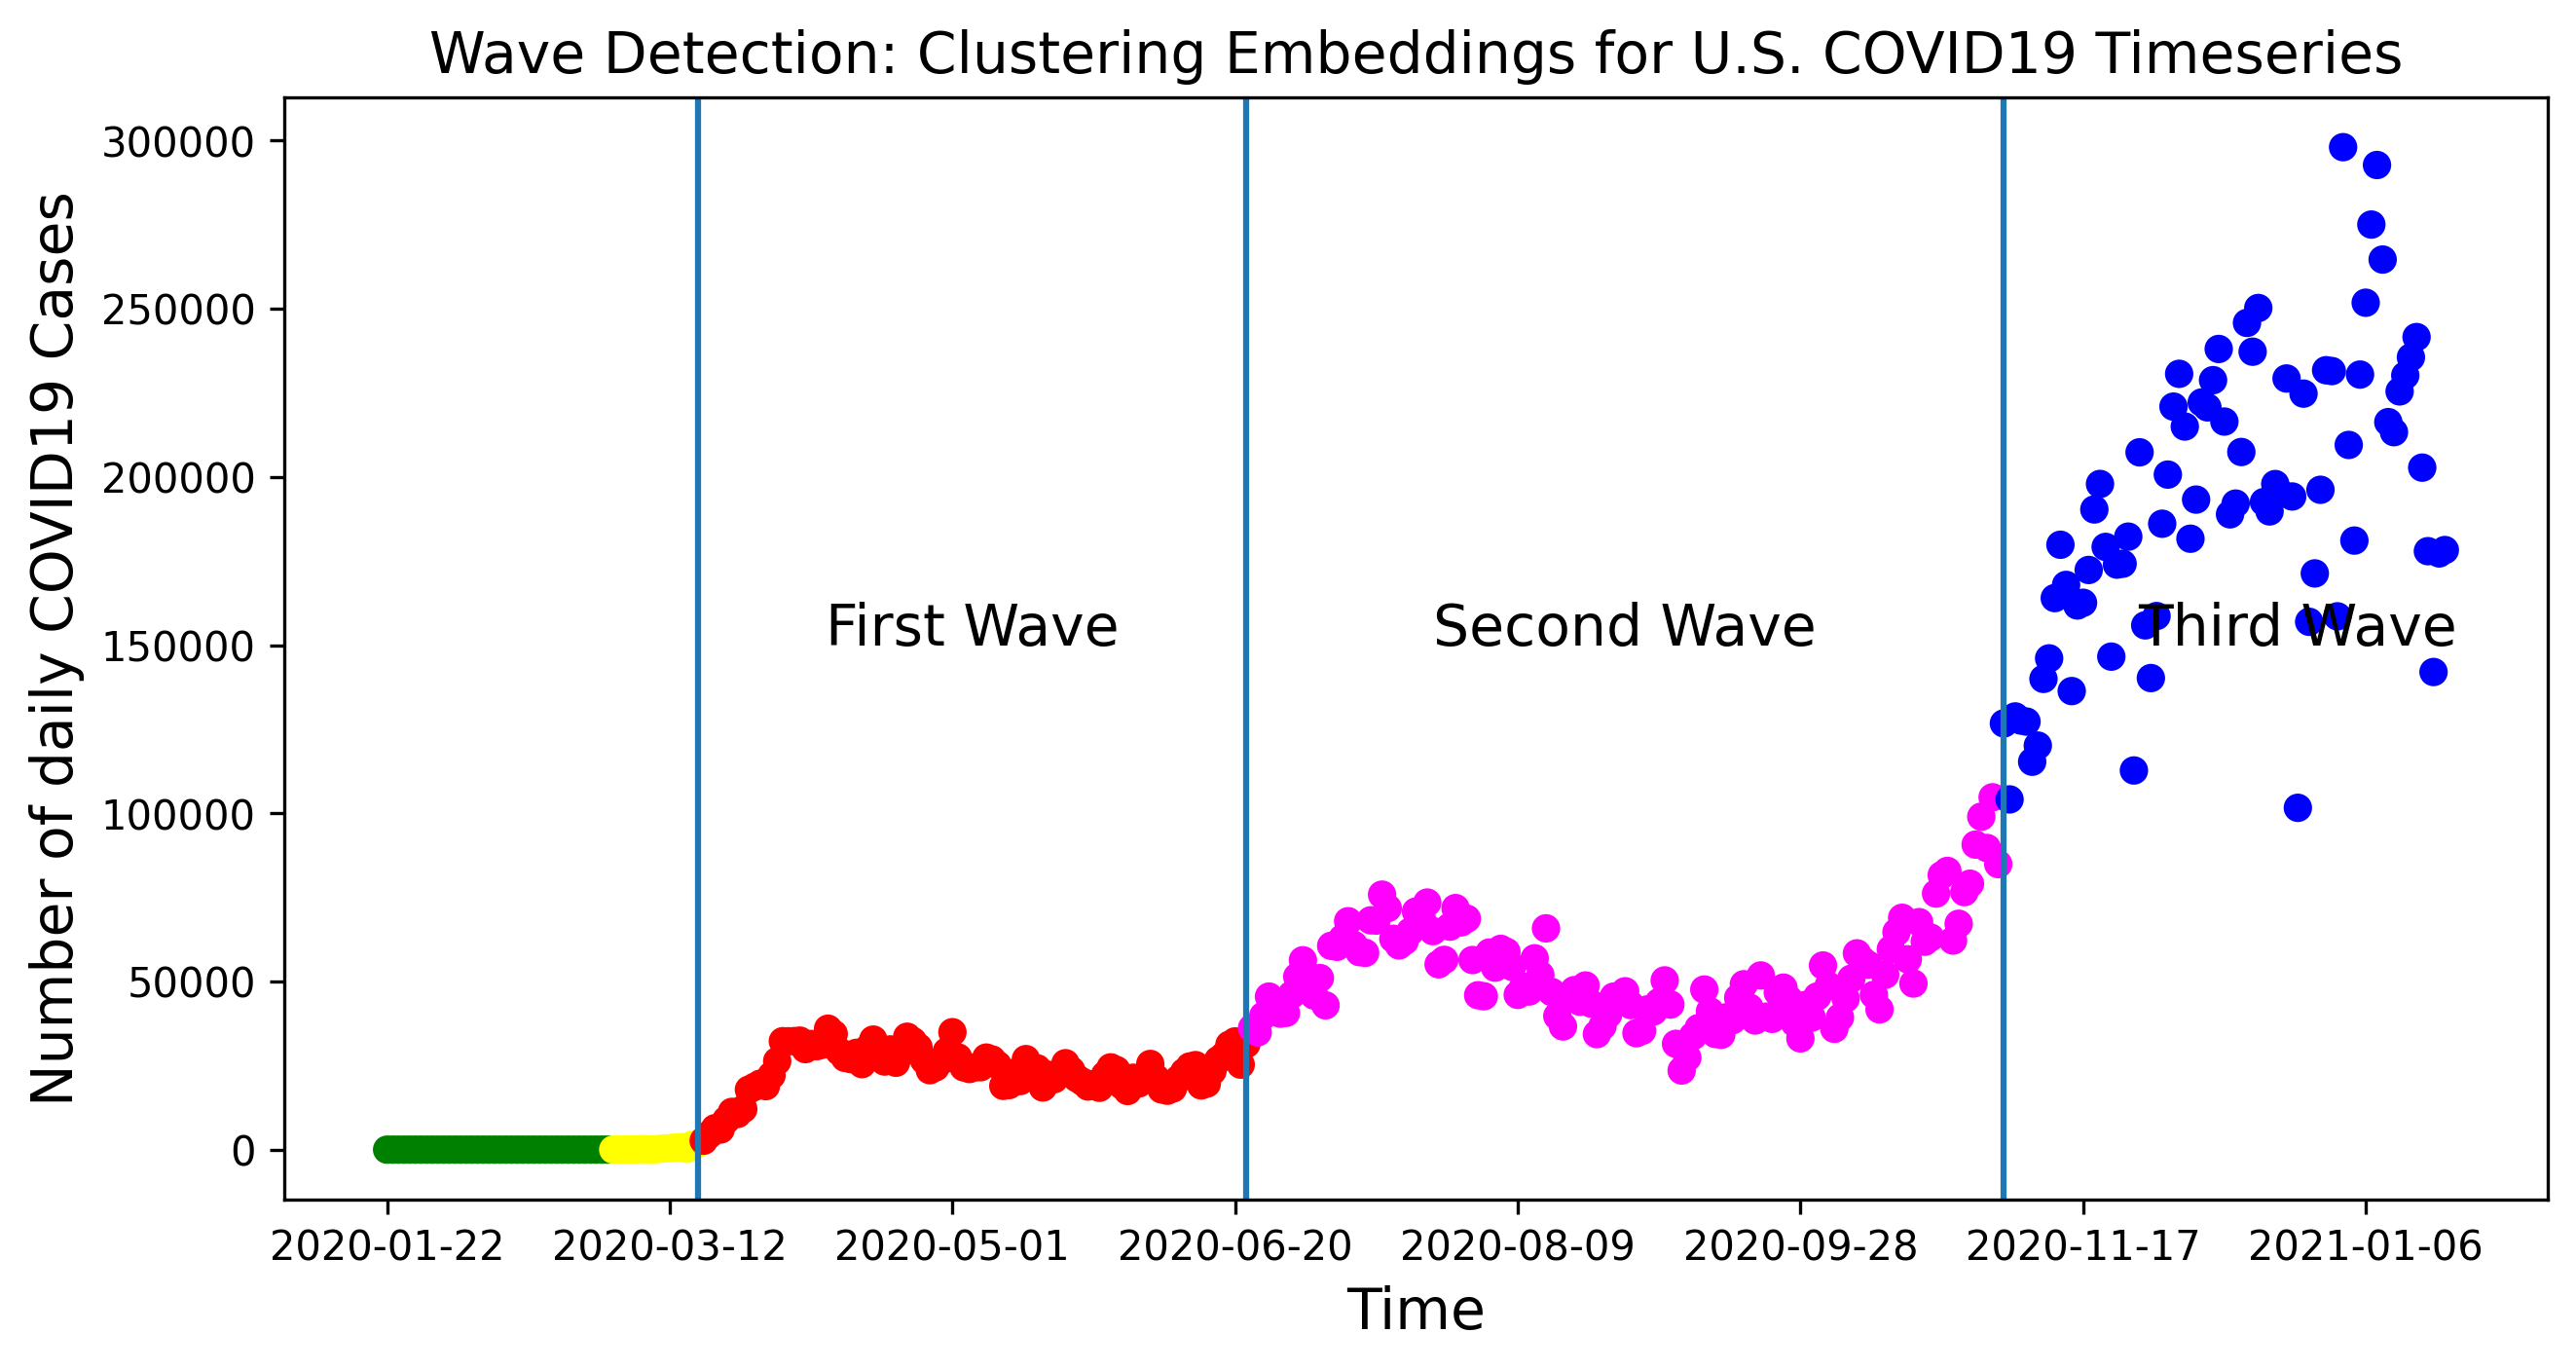

In [155]:
import matplotlib.pyplot as plt

font = {'family': 'DejaVu Sans',
        'color':  'Black',
        'weight': 'normal',
        'size': 14,
        }

plt.figure(figsize=(10,5), dpi=300)
x = range(0,len(segments))
plt.scatter(x_axis,country_cases_raw,color=segments)
plt.xticks(np.arange(0, len(x_axis) + 1, 50))
plt.axvline(x=55)
x_center = (55+152)/2 
plt.text(x_center, 150000, "First Wave", fontdict=font, ha="center")
x_center = (152 + 286)/2 
plt.axvline(x=152)
plt.text(x_center, 150000, "Second Wave", fontdict=font, ha="center")
plt.axvline(x=286)
x_center = (286 + 390)/2 
plt.text(x_center, 150000, "Third Wave", fontdict=font, ha="center")
plt.xlabel("Time", fontdict=font)
plt.ylabel("Number of daily COVID19 Cases", fontdict=font)
plt.title("Wave Detection: Clustering Embeddings for U.S. COVID19 Timeseries", fontdict=font)

### Evaluation

In [28]:
import matrixprofile as mp

def cal_err_rl(data, indices):
    std = []
    for entry in indices:
        log_std = np.log(np.std(data[entry[0]:entry[1]]))
        std.append(log_std)
    return np.mean(std)  

def cal_err_mp(data, regimes):
    std = []
    regimes.sort()
    prev_index = 0
    for entry in regimes:
        log_std = np.log(np.std(data[prev_index:entry]))
        std.append(log_std)
        prev_index = entry
    std = [x for x in std if str(x) != 'nan']
    return np.mean(std)

In [116]:
usa_cases_rl = encoder.encode_window(np.array([[country_cases_raw]]),1)
kmeans_usa_cases = cluster.KMeans(n_clusters=5).fit(np.swapaxes(usa_cases_rl[0, :, :], 0, 1))
segments = utils.find_contiguous(kmeans_usa_cases)
indices_rl = utils.find_indices(segments)

In [117]:
cal_err_rl(country_cases_raw, indices_rl)

9.436872495723604

In [122]:
data = country_cases_raw
profile = mp.compute(data, windows=8)
regimes = mp.discover.regimes(profile, num_regimes = 5)
print(regimes['regimes'])

[ 32  73 124 177 218]


In [123]:
cal_err_mp(country_cases_raw, regimes['regimes'])

7.296220754563623

In [124]:
rl = encoder.encode_window(np.array([[country_exports_raw]]),1)
kmeans_rl = cluster.KMeans(n_clusters=3).fit(np.swapaxes(rl[0, :, :], 0, 1))
segments = utils.find_contiguous(kmeans_rl)
indices_rl = utils.find_indices(segments)

In [125]:
cal_err_rl(country_exports_raw, indices_rl)        

8.986459071580759

In [128]:
data = country_exports_raw
profile = mp.compute(data, windows=8)
regimes = mp.discover.regimes(profile, num_regimes = 3)
print(regimes['regimes'])

[103  44 238]


In [129]:
cal_err_mp(country_exports_raw, regimes['regimes'])

8.680421901185449

In [130]:
rl = encoder.encode_window(np.array([[country_poll_raw]]),1)
kmeans_rl = cluster.KMeans(n_clusters=5).fit(np.swapaxes(rl[0, :, :], 0, 1))
segments = utils.find_contiguous(kmeans_rl)
indices_rl = utils.find_indices(segments)

In [131]:
cal_err_rl(country_poll_raw, indices_rl)        

-2.415562127919999

In [132]:
data = country_poll_raw
profile = mp.compute(data, windows=32)
regimes = mp.discover.regimes(profile, num_regimes = 3)
print(regimes['regimes'])

[691  32 192]


/home/mandarsharma/trans/lib/python3.6/site-packages/matrixprofile/algorithms/regimes.py:81: RuntimeWarning: invalid value encountered in true_divide
  idealized = cross_count / idealized


In [133]:
cal_err_mp(country_poll_raw, regimes['regimes'])

-2.3560375832888223

In [134]:
rl = encoder.encode_window(np.array([[country_pop_raw]]),1)
kmeans_rl = cluster.KMeans(n_clusters=5).fit(np.swapaxes(rl[0, :, :], 0, 1))
segments = utils.find_contiguous(kmeans_rl)
indices_rl = utils.find_indices(segments)

In [135]:
cal_err_rl(country_pop_raw, indices_rl)        

18.269196361357604

In [145]:
data = country_pop_raw
profile = mp.compute(data, windows=8)
regimes = mp.discover.regimes(profile, num_regimes = 5)
print(regimes['regimes'])

[8 0 0 0 0]


In [114]:
cal_err_mp(country_pop_raw, regimes['regimes'])

15.26027975327958

In [115]:
regimes['regimes']

array([0, 0, 0, 0, 8])

In [146]:
rl = encoder.encode_window(np.array([[country_gtemp_raw]]),1)
kmeans_rl = cluster.KMeans(n_clusters=5).fit(np.swapaxes(rl[0, :, :], 0, 1))
segments = utils.find_contiguous(kmeans_rl)
indices_rl = utils.find_indices(segments)

In [147]:
cal_err_rl(country_gtemp_raw, indices_rl)

2.194364976962751

In [148]:
data = country_gtemp_raw
profile = mp.compute(data, windows=8)
regimes = mp.discover.regimes(profile, num_regimes = 3)
print(regimes['regimes'])

[165 205  85]


/home/mandarsharma/trans/lib/python3.6/site-packages/matrixprofile/algorithms/regimes.py:81: RuntimeWarning: invalid value encountered in true_divide
  idealized = cross_count / idealized


In [149]:
cal_err_mp(country_gtemp_raw, regimes['regimes'])

2.2016596522245373